# Домашнее задание №1 по курсу "Генеративный AI" МТСхВШЭ
Выполнила: Ряднинская Елизавета
- Датасет: MNIST

### Шаг 1. Разведывательный анализ данных

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
RANDOM_SEED = 42
DATASET_PATH = "dataset"

In [4]:
# Загрузка датасета с базовой трансформацией
train_dataset = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, download=True, transform=torchvision.transforms.ToTensor())

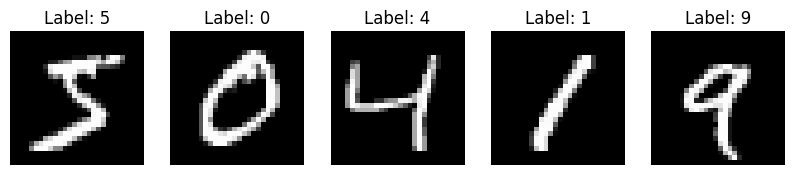

In [5]:
# Визуализация нескольких изображений
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.savefig('labels_examples.png')
plt.show()

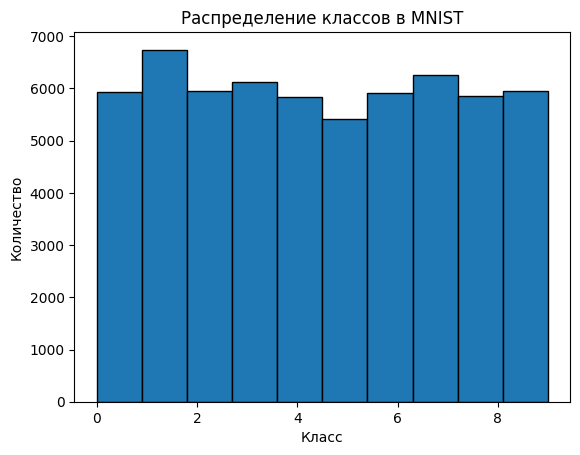

In [6]:
# Распределение классов
train_labels = [label for _, label in train_dataset]
plt.hist(train_labels, bins=10, edgecolor='black')
plt.title('Распределение классов в MNIST')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.savefig('Распределение классов в MNIST.png')
plt.show()

In [7]:
# Статистика для нормализации
imgs = torch.stack([img for img, _ in train_dataset], dim=0)
mean = imgs.mean().item()
std = imgs.std().item()
print(f'Среднее: {mean:.4f}, Стандартное отклонение: {std:.4f}')

#Среднее: 0.1918, Стандартное отклонение: 0.3483

Среднее: 0.1307, Стандартное отклонение: 0.3081


## Обучение модели с неизмененными параметрами

### Шаг 2. Определение классов модели

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
"""
Генератор: Принимает шум z и метку класса labels, объединяет их и генерирует изображение 28x28.
Дискриминатор: Принимает изображение и метку класса, объединяет их и оценивает подлинность.
"""

import torch.nn as nn

# Условный генератор
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super(ConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Преобразование метки в плотное представление
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 128, 7, stride=1, padding=0),  # (latent_dim + num_classes, 1, 1) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # (128, 7, 7) -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),  # (64, 14, 14) -> (1, 28, 28)
            nn.Tanh()  # Вывод в диапазоне [-1, 1]
        )
    
    def forward(self, z, labels):
        labels = self.label_emb(labels)  # Преобразование меток в эмбеддинги
        labels = labels.view(-1, self.num_classes, 1, 1)
        z = z.view(-1, self.latent_dim, 1, 1)
        input = torch.cat([z, labels], dim=1)  # Объединение шума и меток
        return self.model(input)

# Условный дискриминатор
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(1 + num_classes, 64, 4, stride=2, padding=1),  # (1 + num_classes, 28, 28) -> (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # (64, 14, 14) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, stride=1, padding=0),  # (128, 7, 7) -> (1, 1, 1)
            nn.Sigmoid()  # Вероятность реальности
        )
    
    def forward(self, img, labels):
        labels = self.label_emb(labels)
        labels = labels.view(-1, num_classes, 1, 1)
        labels = labels.expand(-1, -1, img.size(2), img.size(3))  # Расширение меток до размера изображения
        input = torch.cat([img, labels], dim=1)  # Объединение изображения и меток
        return self.model(input)

# Классификатор (для оценки сгенерированных изображений)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (64, 14, 14) -> (64, 7, 7)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10),  # (64*7*7) -> (10)
            nn.Softmax(dim=1)  # Вероятности для 10 классов
        )
    
    def forward(self, x):
        return self.model(x)

### Шаг 3. Раздельное обучение моделей

In [10]:
import json

"""
Сохраняем параметры для анализа.
"""

def save_params(model, epoch, loss, filename):
    params = {
        "epoch": epoch,
        "loss": loss,
        "model_state": {k: v.tolist() for k, v in model.state_dict().items()}
    }
    with open(filename, "w") as f:
        json.dump(params, f)

In [11]:
"""
Обучение классификатора
Классификатор обучается отдельно для последующей оценки сгенерированных изображений.
"""

from torch.utils.data import DataLoader
import torch.optim as optim

CLASSIFIER_LEARNING_RATE = 0.0001
CLASSIFIER_BATCH_SIZE = 32
CLASSIFIER_EPOCHS = 20

# Подготовка данных с аугментацией
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std,))
])
train_dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH,
                                                  train=True,
                                                  download=True,
                                                  transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=CLASSIFIER_BATCH_SIZE,
                          shuffle=True)

# Инициализация классификатора
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=CLASSIFIER_LEARNING_RATE)

classifier_losses = []
# Цикл обучения
for epoch in range(CLASSIFIER_EPOCHS):
    classifier.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        
        optimizer.zero_grad()
        outputs = classifier(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')

    avg_loss = running_loss / len(train_loader)
    classifier_losses.append(avg_loss)

    save_params(classifier, epoch+1, running_loss, f"classifier_params_epoch_{epoch+1}.json")

# Сохранение модели
torch.save(classifier.state_dict(), 'classifier.pth')

Epoch 1, Loss: 1.6964
Epoch 2, Loss: 1.6187
Epoch 3, Loss: 1.6015
Epoch 4, Loss: 1.5923
Epoch 5, Loss: 1.5853
Epoch 6, Loss: 1.5809
Epoch 7, Loss: 1.5776
Epoch 8, Loss: 1.5736
Epoch 9, Loss: 1.5709
Epoch 10, Loss: 1.5693
Epoch 11, Loss: 1.5664
Epoch 12, Loss: 1.5651
Epoch 13, Loss: 1.5640
Epoch 14, Loss: 1.5621
Epoch 15, Loss: 1.5607
Epoch 16, Loss: 1.5600
Epoch 17, Loss: 1.5582
Epoch 18, Loss: 1.5572
Epoch 19, Loss: 1.5561
Epoch 20, Loss: 1.5553


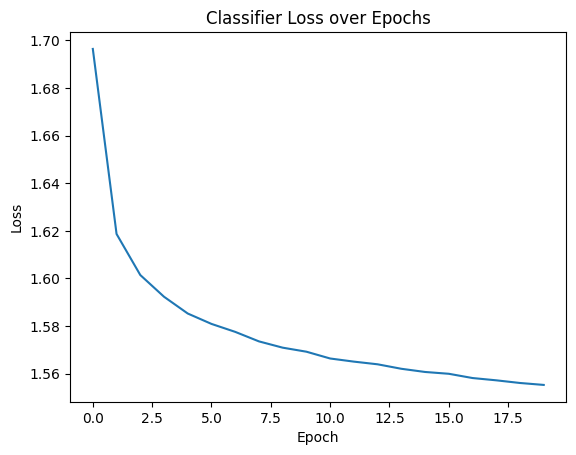

In [12]:
plt.plot(classifier_losses)
plt.title('Classifier Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('classifier_loss.png')
plt.show()

In [14]:
"""
Обучение CGAN
Генератор и дискриминатор обучаются совместно в рамках состязательного процесса.
"""

# Инициализация моделей
latent_dim = 100
num_classes = 10
generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes)
discriminator = ConditionalDiscriminator(num_classes=num_classes)

# Гиперпараметры обучения
DISCRIMINATOR_LEARNING_RATE = 0.0001
GENERATOR_LEARNING_RATE = 0.0001
CGAN_EPOCHS = 20
CGAN_BATCH_SIZE = 32

# Оптимизаторы
d_optimizer = optim.Adam(discriminator.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(0.5, 0.999)) # betas — затухание оценки первого момента
g_optimizer = optim.Adam(generator.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(0.5, 0.999)) # betas — затухание оценки второго момента

# Лосс
adversarial_loss = nn.BCELoss()

# Подготовка данных
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std,))
])
train_dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=CGAN_BATCH_SIZE, shuffle=True)

d_losses, g_losses = [], []
# Обучение CGAN
for epoch in range(CGAN_EPOCHS):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)
        
        # Метки для реальных и фейковых данных
        real_label = torch.ones(batch_size, 1, 1, 1)
        fake_label = torch.zeros(batch_size, 1, 1, 1)
        
        # Обучение дискриминатора
        d_optimizer.zero_grad()
        real_output = discriminator(imgs, labels)
        d_real_loss = adversarial_loss(real_output, real_label)
        
        z = torch.randn(batch_size, latent_dim, 1, 1)
        z = z.to(device)

        fake_labels = torch.randint(0, num_classes, (batch_size,))
        fake_labels = fake_labels.to(device)
        fake_imgs = generator(z, fake_labels)
        fake_output = discriminator(fake_imgs.detach(), fake_labels)
        d_fake_loss = adversarial_loss(fake_output, fake_label)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Обучение генератора
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_imgs, fake_labels)
        g_loss = adversarial_loss(fake_output, real_label)
        
        g_loss.backward()
        g_optimizer.step()
        
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{CGAN_EPOCHS}] Batch [{i}/{len(train_loader)}] '
                  f'D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}')
            
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
        save_params(generator, epoch+1, g_loss.tolist(), f"generator_params_epoch_{epoch+1}.json")
        save_params(discriminator, epoch+1, d_loss.tolist(), f"discriminator_params_epoch_{epoch+1}.json")
    
# Сохранение моделей
torch.save(generator.state_dict(), f'conditional_generator.pth')
torch.save(discriminator.state_dict(), f'conditional_discriminator.pth')

Epoch [1/20] Batch [0/1875] D Loss: 1.5218 G Loss: 0.6317
Epoch [1/20] Batch [100/1875] D Loss: 0.2311 G Loss: 2.3123
Epoch [1/20] Batch [200/1875] D Loss: 0.0602 G Loss: 3.8305
Epoch [1/20] Batch [300/1875] D Loss: 0.0426 G Loss: 4.3401
Epoch [1/20] Batch [400/1875] D Loss: 0.0061 G Loss: 5.4073
Epoch [1/20] Batch [500/1875] D Loss: 0.0507 G Loss: 5.1095
Epoch [1/20] Batch [600/1875] D Loss: 0.0025 G Loss: 6.3965
Epoch [1/20] Batch [700/1875] D Loss: 0.0034 G Loss: 6.7671
Epoch [1/20] Batch [800/1875] D Loss: 0.0015 G Loss: 7.1206
Epoch [1/20] Batch [900/1875] D Loss: 0.0017 G Loss: 7.0916
Epoch [1/20] Batch [1000/1875] D Loss: 0.0006 G Loss: 7.7075
Epoch [1/20] Batch [1100/1875] D Loss: 0.0015 G Loss: 7.7055
Epoch [1/20] Batch [1200/1875] D Loss: 0.0006 G Loss: 8.1826
Epoch [1/20] Batch [1300/1875] D Loss: 0.0004 G Loss: 8.0759
Epoch [1/20] Batch [1400/1875] D Loss: 0.0006 G Loss: 8.1616
Epoch [1/20] Batch [1500/1875] D Loss: 0.0005 G Loss: 8.4126
Epoch [1/20] Batch [1600/1875] D Los

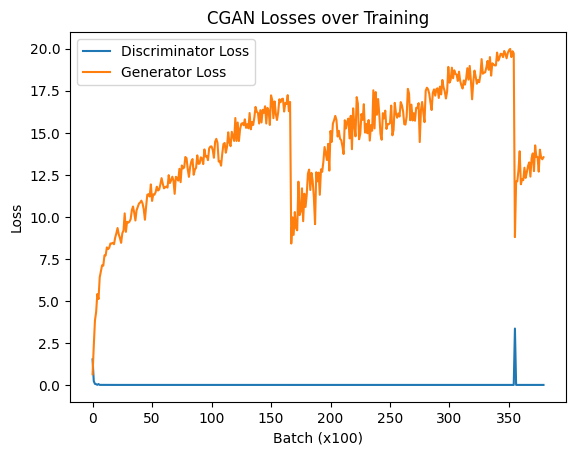

In [15]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('CGAN Losses over Training')
plt.xlabel('Batch (x100)')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cgan_losses.png')
plt.show()

### Шаг 4. Оценка метрик и визуализация

In [16]:
"""
Оценка классификатора
"""

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
classifier.eval()
preds, true_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = classifier(imgs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.02      0.00      0.00      1135
           2       0.15      0.79      0.25      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.10      0.32      0.15       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.03      0.11      0.04     10000
weighted avg       0.03      0.11      0.04     10000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

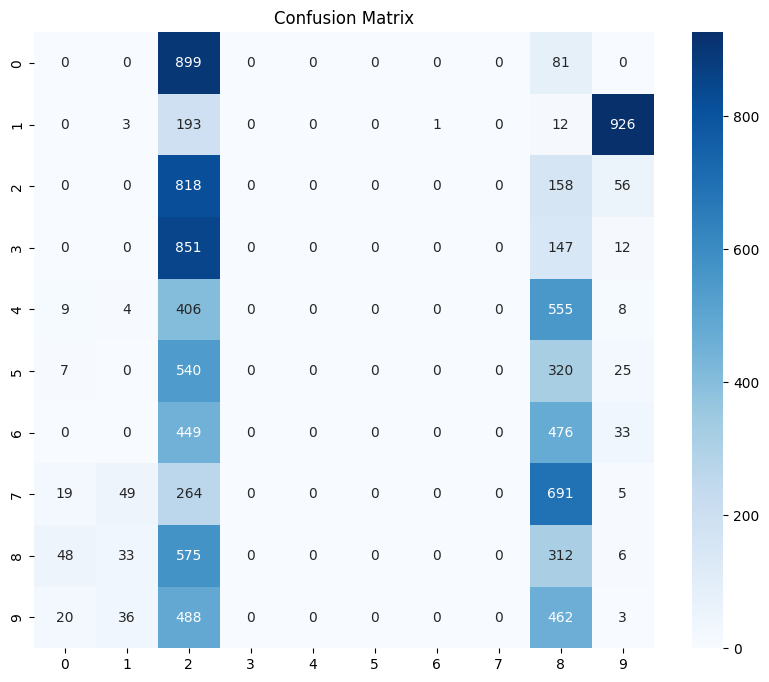

In [17]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

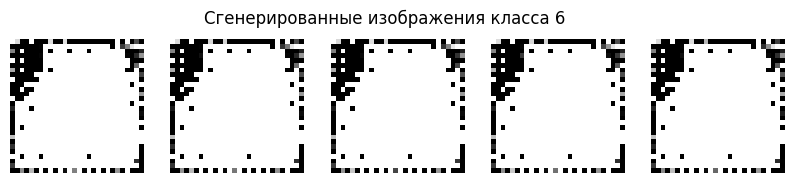

In [ ]:
"""
Визуализация сгенерированных изображений
"""

# Генерация изображений для класса 0
desired_class = 0
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

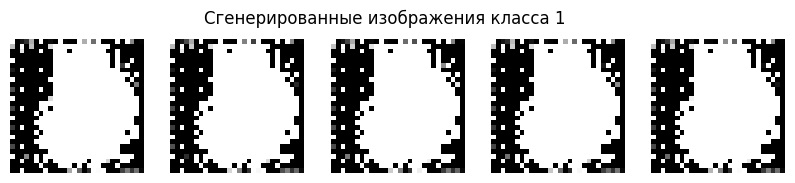

In [106]:

# Генерация изображений для класса 1
desired_class = 1
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

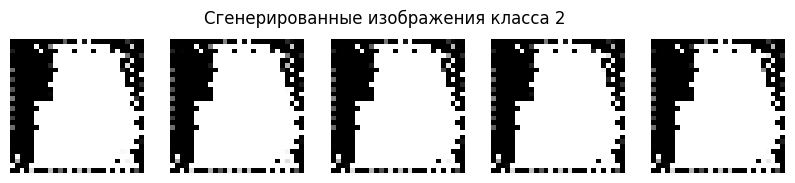

In [107]:

# Генерация изображений для класса 2
desired_class = 2
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

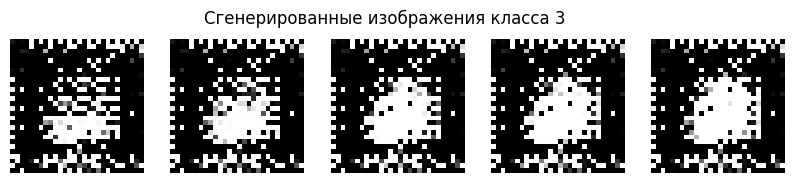

In [108]:
# Генерация изображений для класса 3
desired_class = 3
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

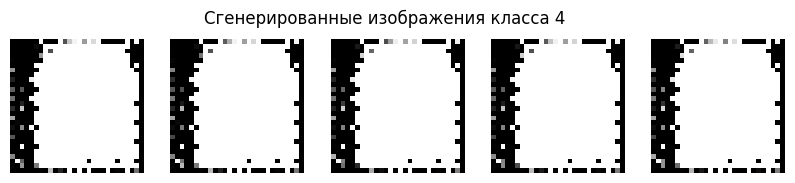

In [109]:
# Генерация изображений для класса 4
desired_class = 4
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

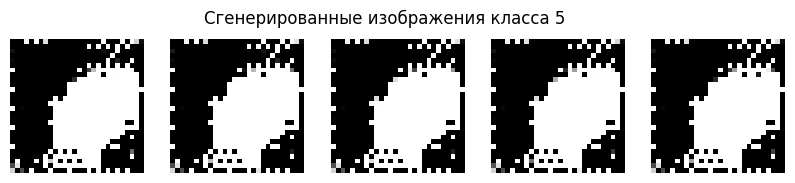

In [110]:
# Генерация изображений для класса 5
desired_class = 5
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

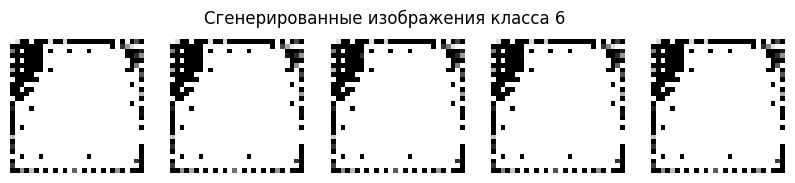

In [111]:
# Генерация изображений для класса 6
desired_class = 6
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

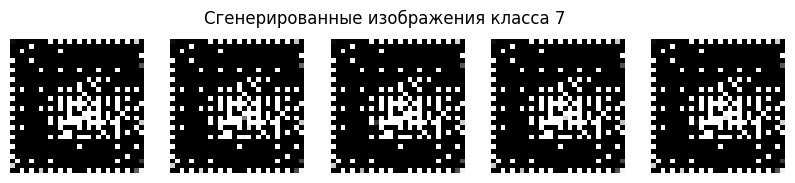

In [112]:
# Генерация изображений для класса 7
desired_class = 7
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

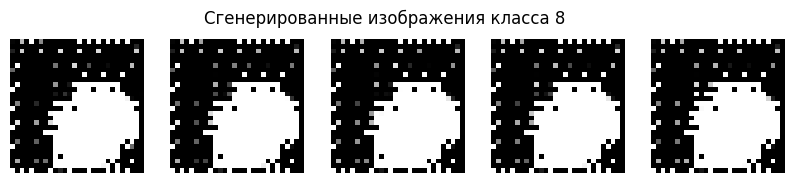

In [113]:
# Генерация изображений для класса 8
desired_class = 8
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

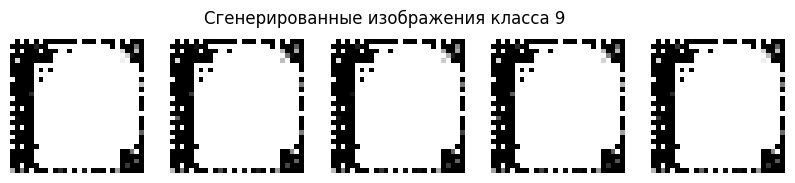

In [114]:
# Генерация изображений для класса 9
desired_class = 9
z = torch.randn(5, latent_dim, 1, 1)
labels = torch.full((5,), desired_class, dtype=torch.long)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

### Шаг 5. Загрузка моделей

In [105]:
# Загрузка
classifier = Classifier()
classifier.load_state_dict(torch.load('classifier.pth'))

generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes)
generator.load_state_dict(torch.load('conditional_generator.pth'))

discriminator = ConditionalDiscriminator(num_classes=num_classes)
discriminator.load_state_dict(torch.load('conditional_discriminator.pth'))

<All keys matched successfully>

### Шаг 6. Интерфейс моделей

Дискриминатор: 0.7558 (вероятность реальности)
Классификатор: Класс 6


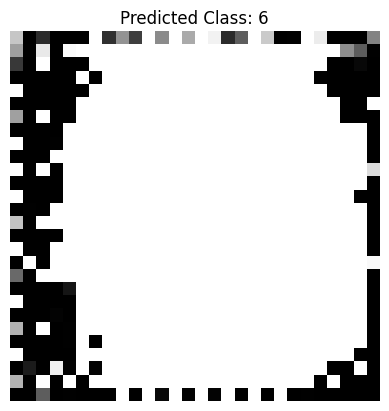

In [115]:
generator.eval()
discriminator.eval()
classifier.eval()

desired_class = 0
z = torch.randn(1, latent_dim, 1, 1)
label = torch.tensor([desired_class])

with torch.no_grad():
    generated_img = generator(z, label)
    disc_pred = discriminator(generated_img, label)
    print(f'Дискриминатор: {disc_pred.item():.4f} (вероятность реальности)')
    class_pred = classifier(generated_img)
    predicted_class = class_pred.argmax(dim=1).item()
    print(f'Классификатор: Класс {predicted_class}')
    plt.imshow(generated_img.squeeze().cpu(), cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.savefig('inference_example_class_0.png')
    plt.show()